# Streetview with linear models
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. Your goal is to build a model that recognizes the correct digit. Here's, we'll use quite simple models and learn why they are not sufficient for this task.

We first download the data from OpenML. Then, we select a few images, and show them together with their correct classification

In [1]:
# General imports
%matplotlib inline
#!pip install openml
import openml as oml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
# Download Streetview data. Takes a while the first time. The dataset is about 1Gb large.
SVHN = oml.datasets.get_dataset(41081)
X, y, cats, attrs = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

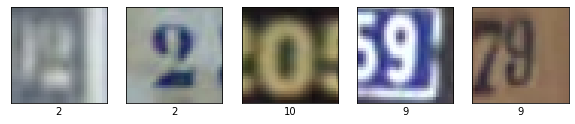

In [3]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n].reshape(32, 32)/255, cmap='gray')
        else:
            axes[n].imshow(X[n].reshape(32, 32, 3)/255)
        axes[n].set_xlabel((y[n]+1)) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,99289) for i in range(5)]
X_random = [X[i] for i in images]
y_random = [y[i] for i in images]
plot_images(X_random, y_random)

## Quick benchmark
First, we'll try the default Logistic Regression and Linear SVMs. We'll also throw in k-Nearest Neighbors as a point of reference. To see whether or models are overfitting, we also evaluate the training set error. This can be done using `cross_validate` instead of  `cross_val_scores`

In [4]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Take a 10% stratified subsample to speed up experimentation
Xs, Xt, ys, yt = train_test_split(X,y, stratify=y, train_size=0.1)

# Evaluate with 3-fold cross-validation.
clfs = [LogisticRegression(), LinearSVC(), KNeighborsClassifier()]
xvals = [cross_validate(clf, Xs, ys, return_train_score= True, n_jobs=-1) for clf in clfs]

In [5]:
# Plot the results
def plot_comparison(clfs,xvals,labels=None):
    fig, ax = plt.subplots()
    width=0.3
    test_scores = [x['test_score'] for x in xvals]
    train_scores = [x['train_score'] for x in xvals]
    ax.barh(np.arange(len(xvals)), np.mean(test_scores, axis=1), width,
            yerr= np.std(test_scores, axis=1), color='green', label='test')
    ax.barh(np.arange(len(xvals))-width, np.mean(train_scores, axis=1), width,
            yerr= np.std(train_scores, axis=1), color='red', label='train')
    for i, te, tr in zip(np.arange(len(xvals)),test_scores,train_scores):
        ax.text(0, i, "{:.4f} +- {:.4f}".format(np.mean(te),np.std(te)), color='white', va='center')
        ax.text(0, i-width, "{:.4f} +- {:.4f}".format(np.mean(tr),np.std(tr)), color='white', va='center')
    if not labels:
        labels = [""]*len(clfs)
    ax.set(yticks=np.arange(len(xvals))-width/2, yticklabels=[c.__class__.__name__+" "+l for c,l in zip(clfs,labels)])
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.show()

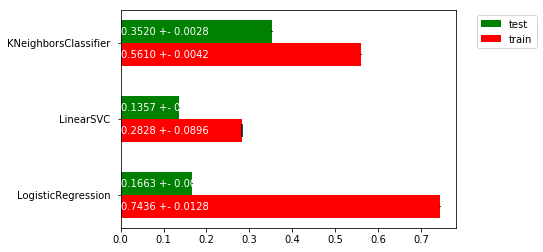

In [6]:
plot_comparison(clfs,xvals)

The plot above shows the scores as bar plots and the variance as error bars. The error bars are hardly noticeable, so the models generated in the 3-fold cross-validation are very stable.

k-NN has by far the best cross-validated test set performance. It still seems to be overfitting since the training score is quite a bit higher than the test score. The second is Logistic regression, but this is clearly overfitting a lot as well. The linear SVM performs worst. It also seems to be overfitting, although less than logistic regression.

Neither of the models does a very good job. Given that this is a 10-class classification problem, the default performance would be 10%, and the best performance is currently 34%, which is not very useful in practice.

The main thing to address right now is the overfitting issue. We can try to add more data or tune the hyperparameters. We can first check the learning curves to see if simply adding more data will help. 

## Learning curves
We draw a learning curve by increasingly adding 1% of data to the training set. We put in a time limit to stop the learning curve when the algorithm becomes too slow.

In [7]:
%%capture
from tqdm import tqdm_notebook as tqdm

# Models
logreg = LogisticRegression(n_jobs=-1)
svm = LinearSVC()
knn = KNeighborsClassifier(n_jobs=-1)
models = [logreg, svm, knn]
run_model = {logreg: True, svm: True, knn: True} # To stop slow models

# Result arrays
modelname_list = []
sample_size_list = []
training_times_list = []
prediction_times_list = []
train_score_list = []
test_score_list = []

# Build the learning curves
for sample_size in tqdm(np.linspace(0.01, 0.1, num=10)):
    if any(v == True for v in run_model.values()): # Check if we are still running any models
        X_sample, _, y_sample, _ = train_test_split(X, y, train_size=sample_size, stratify=y, random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, random_state=42)
        for model in models:
            if run_model[model]: # Only run survivors
                modelname_list.append(model.__class__.__name__)
                sample_size_list.append(sample_size)
                start_time = time.time()
                model.fit(X_train, y_train)
                training_times_list.append(time.time() - start_time)
                start_time = time.time()
                train_score_list.append(model.score(X_train, y_train))
                test_score_list.append(model.score(X_test, y_test)) 
                prediction_times_list.append(time.time() - start_time)
                if training_times_list[-1] > 600 or prediction_times_list[-1] > 600: # Takes too long (more than 10 minutes). Kick model out.
                    run_model[model] = False
                    print(model.__class__.__name__,"takes too long. Stopping at",sample_size)

# Store for later
evals = pd.DataFrame(
    {'algorithm': modelname_list,
     'sample_size': sample_size_list,
     'training_time': training_times_list,
     'prediction_time': prediction_times_list,
     'train_score' : train_score_list,
     'test_score' : test_score_list,
    })

 40%|████      | 4/10 [28:08<41:27, 414.53s/it]

LogisticRegression takes too long. Stopping at 0.05000000000000001


100%|██████████| 10/10 [1:19:27<00:00, 476.80s/it]


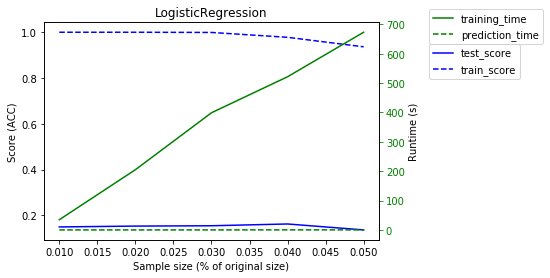

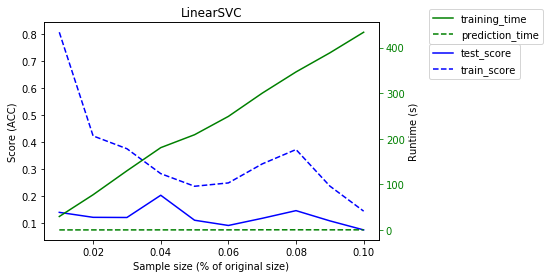

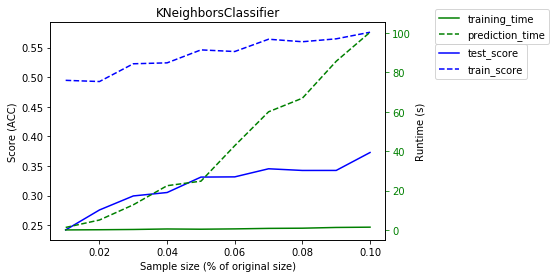

In [8]:
# Plotting the learning curves
for model in models:
    eval_m = evals[evals['algorithm'] == model.__class__.__name__]
    plt.figure()
    plt.plot(eval_m['sample_size'], eval_m['test_score'], color='b')
    plt.plot(eval_m['sample_size'], eval_m['train_score'], '--', color='b')
    ax = plt.gca()
    ax.set_ylabel('Score (ACC)')

    ax2 = ax.twinx()
    ax2.plot(eval_m['sample_size'], eval_m['training_time'], color='g')
    ax2.plot(eval_m['sample_size'], eval_m['prediction_time'], '--', color='g')
    ax2.set_ylabel('Runtime (s)')
    ax2.tick_params('y', colors='g')
    ax.set_xlabel('Sample size (% of original size)')

    ax.legend(bbox_to_anchor=(1.15, 0.9), loc=2, borderaxespad=0.)
    ax2.legend(bbox_to_anchor=(1.15, 0.9), loc=3, borderaxespad=0.)
    plt.title(model.__class__.__name__)

## Data representation
The data is very high-dimensional, which slows down the algorithms. However, we probably don't really
need the color information. In addition, especially for kNN we may get better results if we standardize
or normalize the data first. Let's try that.

In [1]:
# Converts an RGB encoded image to a grayscale image
def rgb2gray(X, dim=32):
    return np.expand_dims(np.dot(X.reshape(len(X), dim*dim, 3), [0.2990, 0.5870, 0.1140]), axis=3)

In [2]:
# Grayscale
X_gray = np.squeeze(rgb2gray(Xs))

# Standardize 
X_st = (X_gray.transpose() - np.mean(X_gray, axis=1)).transpose()
X_st = (X_st.transpose() / np.std(X_st, axis=1)).transpose()

NameError: name 'np' is not defined

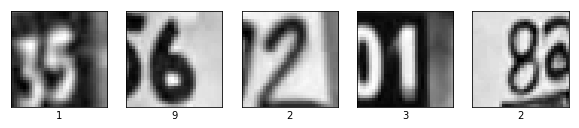

Gray range: [ 8.988 , 174.621 ]


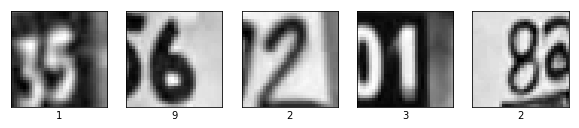

Standardized range: [ -2.439222354928997 , 2.5362443526132585 ]


In [22]:
# Show
plot_images(X_gray[0:5], y, grayscale=True)
print("Gray range: [",X_gray[0:5].min(),",",X_gray[0:5].max(),"]")
plot_images(X_st[0:5], y, grayscale=True)
print("Standardized range: [",X_st[0:5].min(),",",X_st[0:5].max(),"]")

The conversion to greyscale seems successful. The image plotter does an internal standardization, so
we don't see the effect of our standardization in the images, but we can see that the ranges are indeed standized to one
standard deviation around 0. Also note that it is now very clear that we are dealing with dark numbers on light backgrounds, 
but the other way around as well. This may throw off our models.

In [ ]:
# Train
xvals_grey = [cross_validate(clf, X_gray, ys, return_train_score= True, n_jobs=-1) for clf in clfs]
xvals_st = [cross_validate(clf, X_st, ys, return_train_score= True, n_jobs=-1) for clf in clfs]

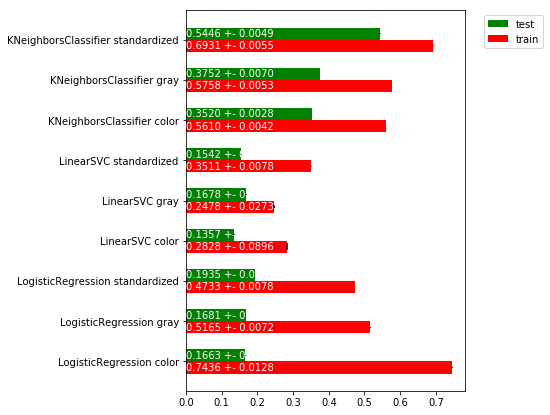

In [49]:
# Plot
#Interweave results for easier comparison
xvals_all = [{}]*len(clfs)*3
xvals_all[0::3], xvals_all[1::3], xvals_all[2::3] = xvals, xvals_grey, xvals_st
labels = ["color", "gray", "standardized"]*3
classifiers = [clf for clf in clfs for i in range(3)]

plt.rcParams['figure.figsize'] = 5, 7
plot_comparison(classifiers,xvals_all,labels)

The grayscale images lead to a slightly better performance for all models. This indicates that to classify the numbers, information about the color is not necessary. The training time (not shown here), has reduced significantly, since there
are now 3x fewer features.

Standardization has a big effect on kNN. This is expected since the data is very high-dimensional. Grayscaling reduced
the dimensionality with a factor 3, but still the effect was limited because the data was not scaled, meaning that every
feature (pixel) can still have a great effect on the distance calculations, even if they have near-constant values. By
standardizing the data, pixels with less variation will have less of an effect in the distance calculations (because 
points will be spaced further apart in that dimension).

In all cases the training set score is significantly higher than the test score, suggesting that all models are still overfitting. Reducing the number of features has helped because it reduces the chance of overfitting. 
Maybe we should reduce the number of features further. This can be done with dimensionality reduction, for instance PCA.

In [127]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Create PCA pipeline and optimize the number of features
param_grid = { 'pca__n_components': list(range(10, 512, 10)) }
pca_search = [GridSearchCV(Pipeline(steps=[('pca', PCA()), ('learner', clf)]), param_grid, n_jobs=-1).fit(X_st,ys) for clf in clfs]

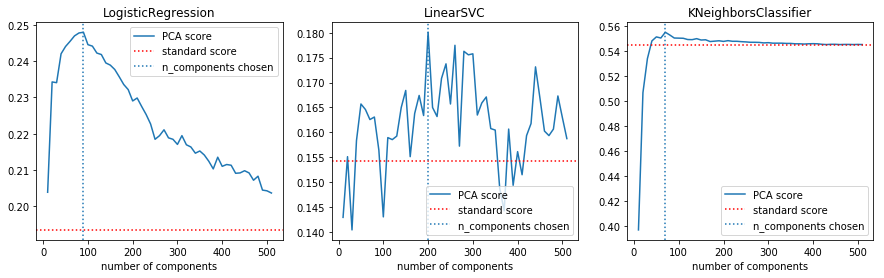

In [133]:
# Plot results
fig, axes = plt.subplots(1, len(clfs),  figsize=(15, 4))

for i, search in enumerate(pca_search):
    axes[i].plot(search.param_grid['pca__n_components'], search.cv_results_['mean_test_score'], label='PCA score')
    axes[i].axhline(y=np.mean(xvals_st[i]['test_score']), color='r', linestyle=':', label='standard score')
    axes[i].axvline(search.best_estimator_.named_steps['pca'].n_components,
                linestyle=':', label='n_components chosen')
    axes[i].set_xlabel('number of components')
    axes[i].set_title(search.best_estimator_.named_steps['learner'].__class__.__name__)
    axes[i].legend() 

PCA significant increases the performance of Logistic Regression, 
and there is a clear optimum for the number of components. The effect on Linear SVM models is mixed, but for certain sets of components the improvement can be significant. Also kNN can be improved slightly. In all cases the optimum is around 90 (around 200 for LinearSVC), significantly less than the original 1024.

## Regularization
Another way to avoid overfitting is to tune the amount of regulization during model training.

In [76]:
# Helper functions
from sklearn.model_selection import GridSearchCV

def run_optimization(estimators):   
    for estimator in tqdm(estimators):
        # Run grid search
        gs = GridSearchCV(
            estimator=estimator['classifier'],
            param_grid=estimator['params'],
            cv=3, return_train_score=True,
            n_jobs=-1)
        
        # Add results
        estimator['result'] = gs.fit(X_st, ys)
        
def plot_optimization(estimators):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
    
    for i, estimator in enumerate(estimators):
        # Get the cross validation results
        results = estimator['result'].cv_results_

        # Get the name and values of the search parameters
        param, param_values = tuple(estimator['params'].items())[0]
                             
        # Plot the results
        axes[i].plot(param_values, results['mean_test_score'], label='Testing accuracy')
        axes[i].plot(param_values, results['mean_train_score'], label='Training accuracy')
        axes[i].set_xlabel(param)
        if i==0:
            axes[i].set_ylabel('Accuracy')
        axes[i].set_title(estimator['name'])
        axes[i].set_xscale(estimator['xscale'])
        axes[i].legend()

In [63]:
estimators = [
    {
        'name': 'k nearest neighbors',
        'classifier': KNeighborsClassifier(),
        'params': {'n_neighbors': np.linspace(1, 50, 5).astype('int')},
        'xscale': 'linear'
    },
    {
        'name': 'logistic regression',
        'classifier': LogisticRegression(),
        'params': {'C': np.logspace(-12, 12, 5)},
        'xscale': 'log'
    },
    {
        'name': 'svm',
        'classifier': LinearSVC(),
        'params': {'C': np.logspace(-12, 12, 5)},
        'xscale': 'log'
    }
]
run_optimization(estimators)

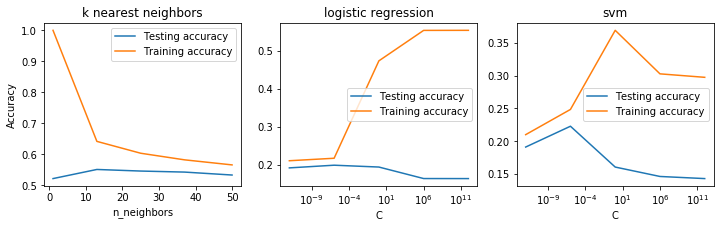

In [77]:
plot_optimization(estimators)

In [80]:
# Overwrite ranges to zoom in and restart
estimators[0]['params'] = {'n_neighbors': np.linspace(5, 15, 10).astype('int')}
estimators[1]['params'] = {'C': np.logspace(-6, -2, 10)}
estimators[2]['params'] = {'C': np.logspace(-6, -2, 10)}
run_optimization(estimators)

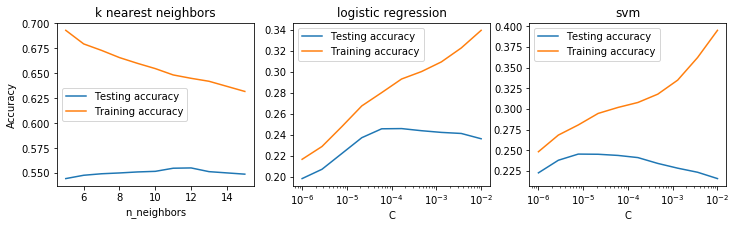

In [81]:
plot_optimization(estimators)

In [87]:
for estimator in estimators:
    print("{}: {}, accuracy {:.4f}".format(estimator['name'],estimator['result'].best_params_,estimator['result'].best_score_))

k nearest neighbors: {'n_neighbors': 12}, accuracy 0.5553
logistic regression: {'C': 0.0001668100537200059}, accuracy 0.2459
svm: {'C': 7.742636826811277e-06}, accuracy 0.2456


Since all hyperparameters control regularization, and keep all other hyperparameters constant, 
we can expect a single optimum. After our initial broad search, we identified the most promising
region and did a second, finer grid search. The optimal hyperparameters are printed above. The
optimal number of neighbors is higher than the default, and the C hyperparameter is much lower
than the default. This confirms that the default models were overfitting. After tuning, the
performance of all models has increased. 

kNN has improved slightly to 55.5% accuracy. Looking at the learning curve earlier, adding more data 
is likley to further improve performance. 
The linear models improved significantly, but don't get better than 25%. This seems to indicate that the current
representation does not allow linear separation of the classes. The latter can be verified by replacing
the linear kernel with a non-linear RBF kernel.

In [134]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

param_grid = {'C': expon(scale=100), 
              'gamma': expon(scale=.1)}
random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid,
                                   n_iter=20, n_jobs=-1)
random_search.fit(X_st, ys)
print("SVM(RBF): {}, accuracy {:.4f}".format(random_search.best_params_,random_search.best_score_))

SVM(RBF): {'C': 29.456150627423057, 'gamma': 0.0028255571775323562}, accuracy 0.6846


The RBF SVM performs a lot better than the linear SVM, and even better than the kNN.

## Misclassifications
It's always good to study the misclassifications of a model. Let's see if the different models misclassify the same or different types of images. 

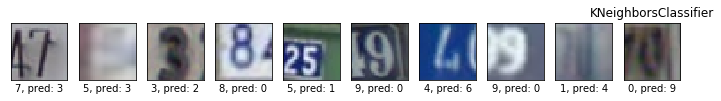

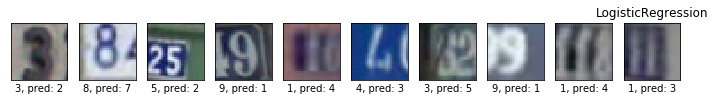

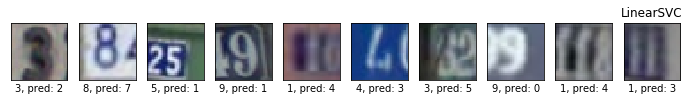

In [154]:
# Get some new datapoints and preprocess
X_new, y_new = Xt[0:1000], yt[0:1000] 
X_new_gray = np.squeeze(rgb2gray(X_new))
X_new_st = (X_new_gray.transpose() - np.mean(X_new_gray, axis=1)).transpose()
X_new_st = (X_new_st.transpose() / np.std(X_new_st, axis=1)).transpose()

# Plotting
def plot_images(X, y, y_pred, title):
    fig, axes = plt.subplots(1, len(X),  figsize=(12, 6))
    plt.title(title)
    for n in range(len(X)):
        axes[n].imshow(X[n].reshape(32, 32, 3)/255)
        axes[n].set_xlabel(str((y[n]+1)%10)+", pred: "+str((y_pred[n]+1)%10))
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

# Get misclassifications
for estimator in estimators:
    # Predict some new data with the optimized models 
    model = estimator['result'].best_estimator_
    y_pred = model.predict(X_new_st)
    estimator['y_pred'] = y_pred
    
    # Get the misclassified examples 
    mask = (y_pred != y_new)
    X_wrong = X_new[mask]
    y_correct = y_new[mask]
    y_wrong = y_pred[mask]
    plot_images(X_wrong[0:10], y_correct[0:10], y_wrong[0:10], model.__class__.__name__)

The linear models misclassify the same imges, but the classifications are not always the same. The kNN sometimes makes different mistakes. A lot of the misclassified images have dark backgrounds. 

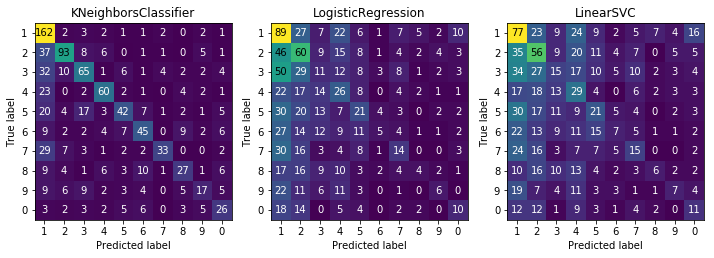

In [158]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3,  figsize=(12, 4))
for c, estimator in enumerate(estimators):
    # Get confusion matrix
    cm = confusion_matrix(y_new, estimator['y_pred'])
    # Plot
    axes[c].imshow(cm)
    axes[c].set(xticks=(np.arange(10)),
       yticks=(np.arange(10)),
       title=estimator['result'].best_estimator_.__class__.__name__,
       ylabel='True label',
       xlabel='Predicted label')
    axes[c].set_xticklabels(np.char.mod('%d', (np.arange(10) + 1) % 10))
    axes[c].set_yticklabels(np.char.mod('%d', (np.arange(10) + 1) % 10))
    axes[c].grid(False)

    for i in range(10):
        for j in range(10):
            axes[c].text(j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] < (cm.max() / 2) else 'black')

Looking at the confusion matrices for the first 1000 predictions, 
oftentimes a number is misclassified as a 1. This could be because 1's are more prevalent in the dataset.
This imbalance can cause the models to be biased towards predicting '1' more often. Other numbers that are often
confused are 3-5, 2-3, and 5-6.  

## Interpreting models
A useful property of linear models is that we can interpret what the model has leaerned by looking at which coefficients get higher weights. In this case the coefficients are the weights for each pixel, so we can plot them as pixels to see what the model is paying attention to. Since linear models are binary and trained in a one-vs-all manner, we get coefficients for every class.

Let's start by training the linear regression with the optimized hyperparameters on all the data and plotting the coefficients.

In [5]:
# Plot the coefficients
def plot_coef(model):
    fig, axes = plt.subplots(1, 10,  figsize=(16, 8))
    plt.title("{}, C={:.2E}".format(model.__class__.__name__,model.get_params()['C']))
    for n, coef in enumerate(model.coef_):
        axes[n].imshow(coef.reshape(32, 32))
        axes[n].set_xlabel((n+1)%10)
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show()

In [6]:
# Preprocess the entire dataset
X_all_gray = np.squeeze(rgb2gray(X))
X_all_st = (X_all_gray.transpose() - np.mean(X_all_gray, axis=1)).transpose()
X_all_st = (X_all_st.transpose() / np.std(X_all_st, axis=1)).transpose()

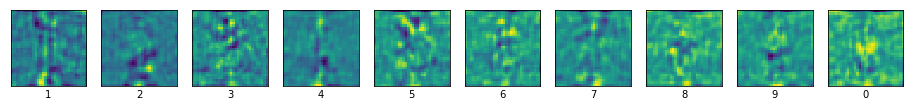

In [196]:
# Fit coefficients and plot
c_opt = estimators[1]['result'].best_params_['C']
model = LogisticRegression(C=c_opt, n_jobs=-1).fit(X_all_st,y)
plot_coef(model)

We can sort of recognize the number that needs to be recognized in the plotted coefficients. The 1,2,3 are quite clear. Overall, the 'edges' of a number seem to get a higher weights than pixels 'inside' the numbers. The models still pay a lot of attention to the background, which is probably why they are are so easily confused.

Since we trained on more data, the optimal C value may have shifted a bit. Let's visualize the models for a range of C values.

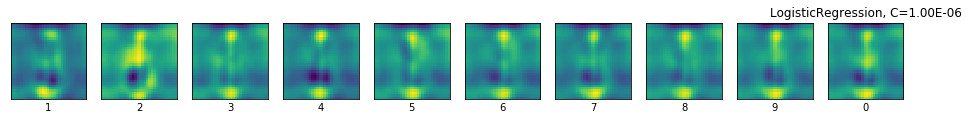

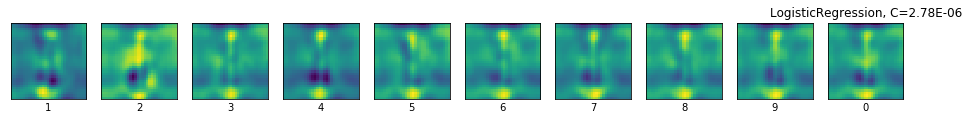

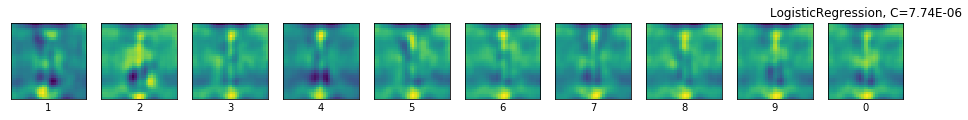

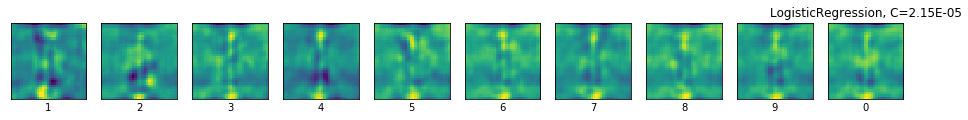

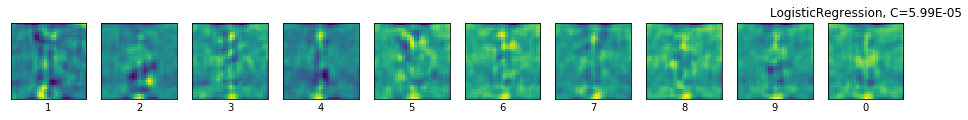

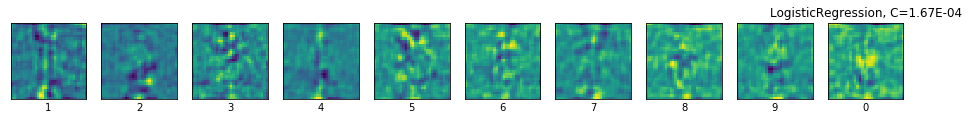

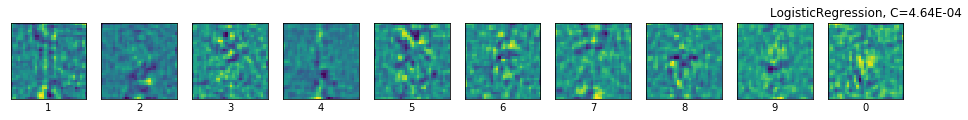

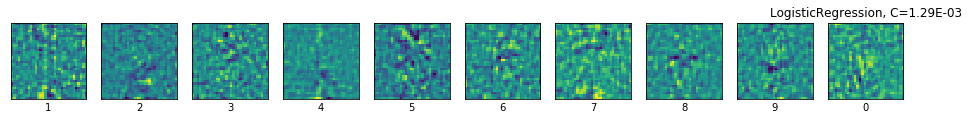

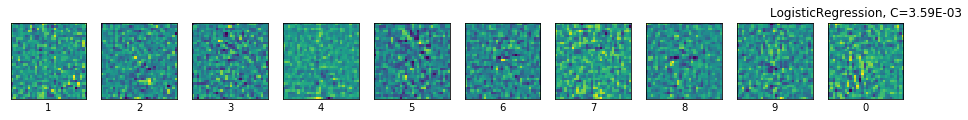

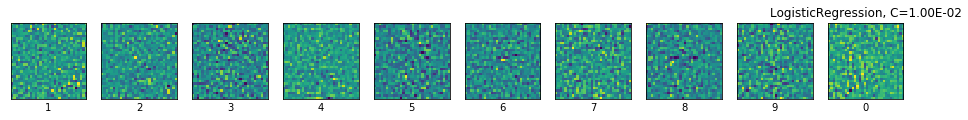

In [209]:
for c in np.logspace(-6, -2, 10):
    model = LogisticRegression(C=c, n_jobs=-1).fit(X_all_st,y)
    plot_coef(model)

The 'clearest' numbers appear around C=4.64e-4, slightly up from C=1e-4. This makes sense since more data means less overfitting, so we can allow a bit less regularization. Looking at the extremes, we see that for small C values, the models are regularized too much and hence underfitting. The figures for all the numbers are almost identical. For larger C values, the models quickly overfit and the pixel weights seem mostly random. Replacing Logistic regression with a linear SVM yields almost identical results.

In [8]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

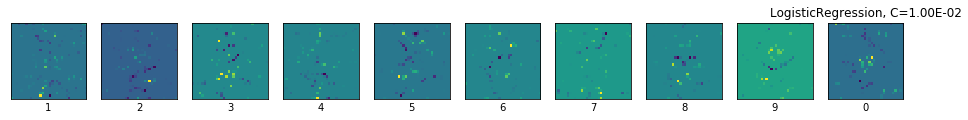

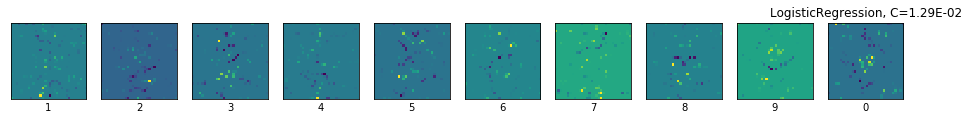

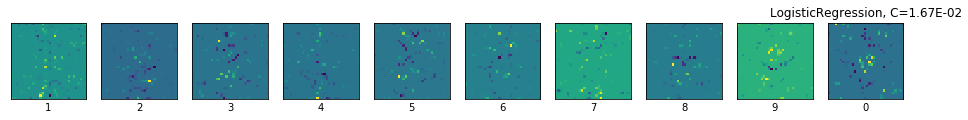

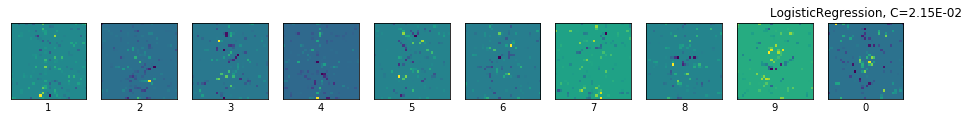

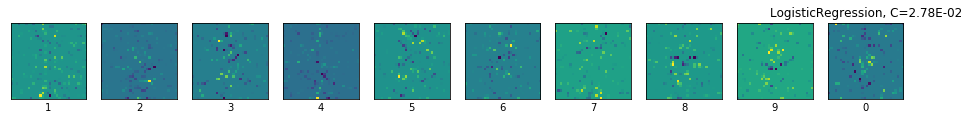

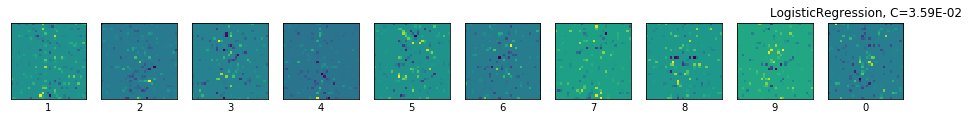

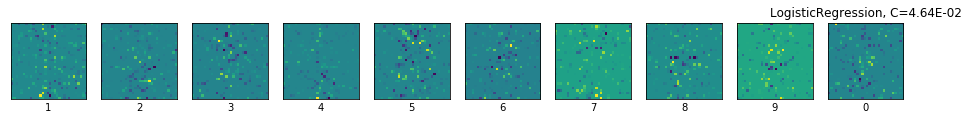

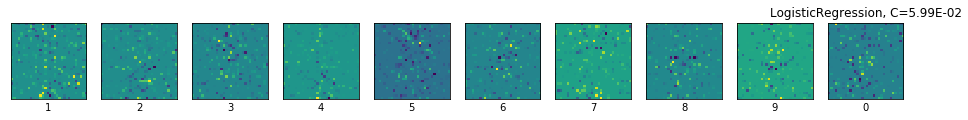

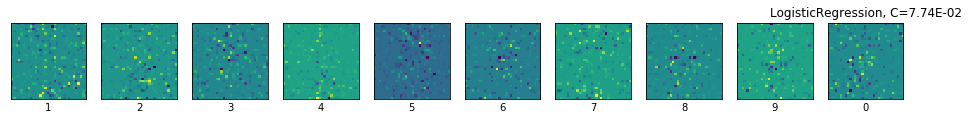

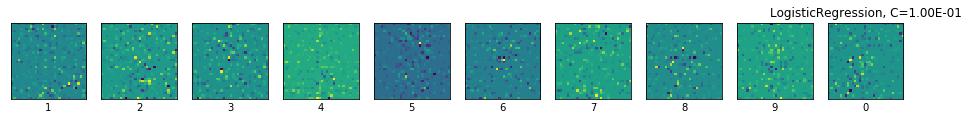

In [9]:
# With l1
for c in np.logspace(-2, -1, 10):
    model = LogisticRegression(C=c, penalty='l1', n_jobs=-1).fit(X_all_st,y)
    plot_coef(model)

### Final notes
None of the linear models does a particularly good job classifying the images. There are several problems with the representation used:
* Numbers can be dark on a light background, or vice versa
    * We need a representation that captures the boundaries rather than the numbers themselves.
* The location and scale of a number can differ
    * We need a translation-invariant and scale-invariant representation
    * There exist techniques for this (e.g. SIFT)
    * In general, convolutional neural nets will work better